<a href="https://colab.research.google.com/github/ubong-essien/ensemble_classification/blob/main/Ensembleforge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

# New Section

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/loca

KNN Accuracy: 0.9473684210526315
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        43
           1       0.96      0.96      0.96        71

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

NaiveBayes Accuracy: 0.9649122807017544
NaiveBayes Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

LogisticRegression Accuracy: 0.9736842105263158
LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:37:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "C", "penalty" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:37:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "C", "penalty" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:37:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "C", "penalty" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:37:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "C", "

Stacking Ensemble Model Accuracy: 0.9736842105263158
Confusion Matrix:
[[41  2]
 [ 1 70]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Feature importances for KNN: None
Feature importances for NaiveBayes: None
Feature importances for LogisticRegression: None


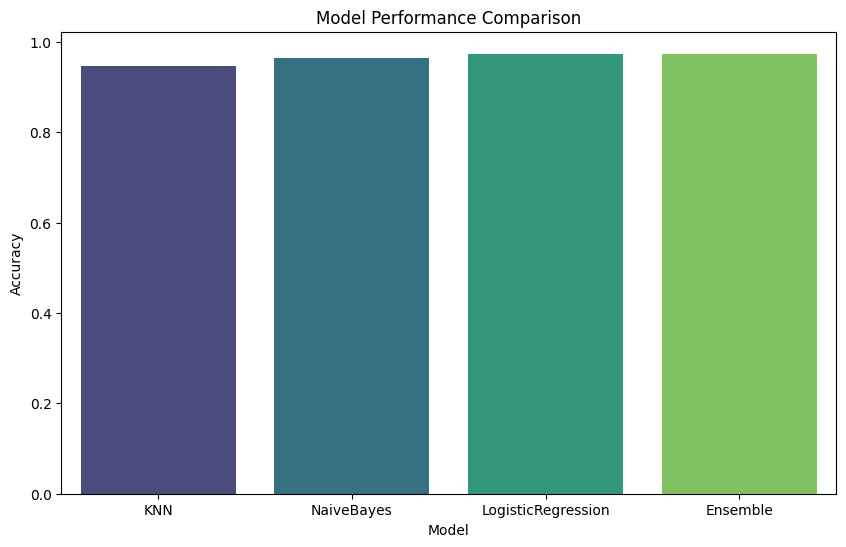

In [21]:
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline

class EnsembleForge:
    def __init__(self, base_classifiers, meta_model_name, preprocessing_steps=None):
        self.base_classifiers = base_classifiers
        self.meta_model_name = meta_model_name
        self.preprocessing_steps = preprocessing_steps
        self.trained_base_models = {}
        self.ensemble_model = None


    def load_dataset(self,input_file,target_column):
        try:
            dataset = pd.read_csv(input_file)  # Load data from CSV file
            X = dataset.drop(columns=[target_column])  # Input features (remove target column)
            y = dataset[target_column]  # Target variable
            return X, y
        except FileNotFoundError:
            print("Input file not found.")
        except Exception as e:
            print("An error occurred while loading the dataset:", str(e))

    def train_base_models(self, X_train, y_train, cv, scoring):
        trained_base_models = {}
        for name, (model, hyperparameters) in self.base_classifiers.items():
            pipeline_steps = [('scaler', StandardScaler()), ('model', clone(model))]

            # Create pipeline
            pipeline = Pipeline(pipeline_steps)

            if hyperparameters:
                # Combine hyperparameters for the scaler and model
                all_hyperparameters = {f'model__{param}': value for param, value in hyperparameters.items()}

                try:
                    # Perform hyperparameter tuning using RandomizedSearchCV
                    random_search = RandomizedSearchCV(pipeline, all_hyperparameters, n_iter=10, cv=cv, scoring=scoring, random_state=42)
                    random_search.fit(X_train, y_train)

                    # Get the best model from the random search
                    best_model = random_search.best_estimator_

                    # Train the best model on the entire training set
                    best_model.fit(X_train, y_train)

                    trained_base_models[name] = best_model

                    # Check if the model supports feature importance analysis
                    self.try_feature_importance_analysis(name, best_model)

                except Exception as e:
                    logging.error(f"Error training base model {name}: {str(e)}")
            else:
                # If no hyperparameters are provided, train the model without hyperparameter tuning
                try:
                    pipeline.fit(X_train, y_train)
                    trained_base_models[name] = pipeline

                    # Check if the model supports feature importance analysis
                    self.try_feature_importance_analysis(name, pipeline)

                except Exception as e:
                    logging.error(f"Error training base model {name}: {str(e)}")

        return trained_base_models


    def try_feature_importance_analysis(self, name, model):
        try:
            # Access feature importances
            importances = model.named_steps['model'].feature_importances_
            self.log_feature_importance(name, importances)
        except (AttributeError, KeyError):
            # Model doesn't support feature importances
            self.log_feature_importance_error(name, None)

    def log_feature_importance(self, name, importances):
        print(f"Feature importances for {name}: {importances}")

    def log_feature_importance_error(self, name, error):
        logging.warning(f'{name} does not support feature importance analysis. Error: {error}')

    def get_default_base_hyperparameters(self, base_model_name):
        # Define default hyperparameters for each base model
        default_hyperparameters = {
            'RandomForest': {'n_estimators': 100, 'max_depth': None},
            'GradientBoosting': {'n_estimators': 100, 'learning_rate': 0.1},
            'SVM': {'C': 1.0, 'kernel': 'rbf'},
            'LogisticRegression': {'C': [1.0], 'penalty': ['l2'],'max_iter': 1000},
            'NaiveBayes': {},  # No hyperparameters for NaiveBayes
            'KNN': {'n_neighbors': 5},
            # Add defaults for other base models as needed
        }

        return default_hyperparameters.get(base_model_name, {})  # Return defaults if available, otherwise empty dict

    def train(self, X_train, y_train, meta_hyperparameters=None, cv=None, scoring='accuracy'):
        # Apply preprocessing steps if provided
        if self.preprocessing_steps:
            base_classifiers = {
                name: (clone(model).set_params(**hyperparameters), hyperparameters) for name, (model, hyperparameters) in self.base_classifiers.items()
            }
        else:
            base_classifiers = {name: (clone(model).set_params(**hyperparameters), hyperparameters) for name, (model, hyperparameters) in self.base_classifiers.items()}

        # Train the base models
        self.trained_base_models = self.train_base_models(X_train, y_train, cv, scoring)

        # Create the stacking ensemble model with the specified meta-model
        meta_model_class = self.get_meta_model_class()
        self.ensemble_model = StackingClassifier(
            estimators=[(name, model) for name, model in self.trained_base_models.items()],
            final_estimator=meta_model_class(**meta_hyperparameters) if meta_hyperparameters else meta_model_class(),
            cv=cv
        )

        # Train the stacking ensemble model
        self.ensemble_model.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        # Make predictions using the stacking ensemble model
        ensemble_predictions = self.ensemble_model.predict(X_test)

        # Evaluate the performance of the ensemble model
        accuracy = accuracy_score(y_test, ensemble_predictions)
        print(f'Stacking Ensemble Model Accuracy: {accuracy}')

        # Confusion Matrix and Classification Report
        cm = confusion_matrix(y_test, ensemble_predictions)
        print(f'Confusion Matrix:\n{cm}')

        # Classification Report
        cr = classification_report(y_test, ensemble_predictions)
        print(f'Classification Report:\n{cr}')

        # Feature Importance Analysis
        self.feature_importance_analysis(X_test, y_test)

    def feature_importance_analysis(self, X_test, y_test):
        # Perform feature importance analysis for each base model
        for name, model in self.trained_base_models.items():
            try:
                importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else None
                self.log_feature_importance(name, importances)
            except Exception as e:
                self.log_feature_importance_error(name, e)

    def get_meta_model_class(self):
      meta_model_mapping = {
          'linearregression': 'sklearn.linear_model',
          'logisticregression': 'sklearn.linear_model',
          'svm': 'sklearn.svm',
          'randomforest': 'sklearn.ensemble',
          'xgbclassifier': 'xgboost',
          'lgbmclassifier': 'lightgbm',
          'your_custom_model': 'your_custom_module',
      }

      meta_model_module = meta_model_mapping.get(self.meta_model_name.lower())

      if meta_model_module:
          if self.meta_model_name.lower() == 'svm':
              return getattr(__import__(meta_model_module, fromlist=['SVC']), 'SVC')
          elif self.meta_model_name.lower() == 'randomforest':
              return getattr(__import__(meta_model_module, fromlist=['RandomForestClassifier']), 'RandomForestClassifier')
          elif self.meta_model_name.lower() == 'xgbclassifier':
              return getattr(__import__(meta_model_module, fromlist=['XGBClassifier']), 'XGBClassifier')
          elif self.meta_model_name.lower() == 'lgbmclassifier':
              return getattr(__import__(meta_model_module, fromlist=['LGBMClassifier']), 'LGBMClassifier')
          else:
              return getattr(__import__(meta_model_module, fromlist=[self.meta_model_name]), self.meta_model_name)
      else:
          raise ValueError(f"Unsupported meta-model: {self.meta_model_name}")





    def visualize_performance(self, X_test, y_test):
            # Visualize performance of base models and ensemble model
            base_models_names = list(self.trained_base_models.keys())
            base_models = list(self.trained_base_models.values())

            # Accuracy comparison
            base_models_accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in base_models]
            ensemble_accuracy = accuracy_score(y_test, self.ensemble_model.predict(X_test))

            plt.figure(figsize=(10, 6))
            sns.barplot(x=base_models_names + ['Ensemble'], y=base_models_accuracies + [ensemble_accuracy], palette='viridis')
            plt.title('Model Performance Comparison')
            plt.xlabel('Model')
            plt.ylabel('Accuracy')
            plt.show()



    def train_and_evaluate(self, X_train, y_train, X_test, y_test, meta_hyperparameters=None, cv=None, scoring='accuracy', use_grid_search=False):
            # Apply preprocessing steps if provided
            if self.preprocessing_steps:
                base_classifiers = {
                    name: (clone(model).set_params(**hyperparameters), hyperparameters) for name, (model, hyperparameters) in self.base_classifiers.items()
                }
            else:
                base_classifiers = {name: (clone(model).set_params(**hyperparameters), hyperparameters) for name, (model, hyperparameters) in self.base_classifiers.items()}

            # Train the base models
            self.trained_base_models = self.train_base_models(X_train, y_train, cv, scoring)

            # Report accuracy for each base model
            for name, model in self.trained_base_models.items():
                predictions = model.predict(X_test)
                accuracy = accuracy_score(y_test, predictions)
                print(f'{name} Accuracy: {accuracy}')
                print(f'{name} Classification Report:\n{classification_report(y_test, predictions)}')

            # Create the stacking ensemble model with the specified meta-model
            meta_model_class = self.get_meta_model_class()

            # Adjust hyperparameter tuning method based on use_grid_search
            search_method = GridSearchCV if use_grid_search else RandomizedSearchCV

            # Set up the meta-model hyperparameters
            meta_hyperparameters = meta_hyperparameters or {}

            # Use StratifiedKFold to address class imbalances
            cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42) if cv else None

            # Convert single values to lists in hyperparameters
            meta_hyperparameters = {key: [value] if not isinstance(value, (list, np.ndarray)) else value for key, value in meta_hyperparameters.items()}

            # Use the selected hyperparameter tuning method
            # search = search_method(
            #     estimator=meta_model_class(),
            #     param_distributions=meta_hyperparameters,
            #     cv=cv,
            #     scoring=scoring,
            #     n_iter=10 if use_grid_search else 100

            # )
             # Use the selected hyperparameter tuning method
            if(use_grid_search==False):
              #if Randomized SearchCV is used
              search = search_method(
                estimator=meta_model_class(),
                param_distributions=meta_hyperparameters,
                scoring=scoring if isinstance(self.trained_base_models[next(iter(self.trained_base_models))], (SVC, StackingClassifier, KNeighborsClassifier)) else 'neg_mean_squared_error',
                n_iter=3 if not use_grid_search else 100  # Adjust n_iter for RandomizedSearchCV
            )
            else:
              #if GridsearchCv is used
              search = search_method(
                  estimator=meta_model_class(),
                  param_grid=meta_hyperparameters,
                  scoring=scoring if isinstance(self.trained_base_models[next(iter(self.trained_base_models))], (SVC, StackingClassifier, KNeighborsClassifier)) else 'neg_mean_squared_error',
                  # n_iter=10 if not use_grid_search else 100  # Adjust n_iter for RandomizedSearchCV
              )

            # Train the stacking ensemble model
            self.ensemble_model = StackingClassifier(
                estimators=[(name, model) for name, model in self.trained_base_models.items()],
                final_estimator=search,
                cv=cv
            )

            self.ensemble_model.fit(X_train, y_train)

            # Evaluate the ensemble model
            self.evaluate(X_test, y_test)

            # Visualize performance
            self.visualize_performance(X_test, y_test)


# Example usage with preprocessing and hyperparameter tuning
# X, y = load_diabetes(return_X_y=True)
# X, y = load_breast_cancer(return_X_y=True)
# X, y = load_breast_cancer(return_X_y=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# logistic_regression = LogisticRegression(max_iter=500)
# Define base classifiers and their optional hyperparameters
base_classifiers = {
    # 'RandomForest': (RandomForestClassifier(), {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [4, 5, 7]}),
    # 'SVM': (SVC(), {'C': [1.0], 'kernel': ['rbf']}),
    'NaiveBayes': (GaussianNB(), {}),
    'LogisticRegression': (LogisticRegression(), {'C': [1.0], 'penalty': ['l1', 'l2']})

}




inputs_file ="/content/drive/MyDrive/dataset1.csv"
target_column = "price_range"

# Specify the meta-model name (e.g., 'LogisticRegression', 'XGBClassifier', 'LGBMClassifier')
meta_model_name = 'XGBClassifier'

# Define meta-model hyperparameters
meta_hyperparameters = {'C': 1.5, 'penalty': 'l2'}  # Adjust the 'C' value as needed
# meta_hyperparameters = {}  # Adjust the 'C' value as needed

# Define preprocessing steps
preprocessing_steps = [('scaler', StandardScaler())]

# Set up logging
logging.basicConfig(level=logging.INFO)

# Create and train the stacking framework
stacking_framework = EnsembleForge(base_classifiers, meta_model_name, preprocessing_steps)
# X,y = stacking_framework.load_dataset(inputs_file,target_column)
breast_cancer_data = load_breast_cancer()

# Extract features (X) and target variable (y) from the dataset
X_breast_cancer, y_breast_cancer = breast_cancer_data.data, breast_cancer_data.target

# Split the dataset into training and testing sets
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
    X_breast_cancer, y_breast_cancer, test_size=0.2, random_state=42
)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
stacking_framework.train_and_evaluate(X_train_bc, y_train_bc,X_test_bc, y_test_bc, meta_hyperparameters,use_grid_search=False)

# Evaluate the stacking framework on the test set
# stacking_framework.evaluate(X_test_bc, y_test_bc)
